# Cat vs Dog Classifier 
### With Transfer Learning techniques like Fine Tuning

In [1]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.05G/1.06G [00:12<00:00, 57.4MB/s]
100% 1.06G/1.06G [00:12<00:00, 91.2MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Build a CNN Model using Fine Tuning

### Importing Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.applications.vgg16 import VGG16

### Creating Generators
##### Helpful for processing huge data Converts big data to batches

In [6]:
train_data = keras.utils.image_dataset_from_directory(
    '/content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150, 150)
)

Found 20000 files belonging to 2 classes.


In [7]:
test_data = keras.utils.image_dataset_from_directory(
    '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150, 150)
)

Found 5000 files belonging to 2 classes.


### Normalizing the inputs

In [8]:
# Normalize
def normalize(images, label):
  img = tf.cast(images/255. , tf.float32)
  return img, label

train_data = train_data.map(normalize)
test_data = test_data.map(normalize)

### Build model using VggNET16

In [9]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
conv_base.trainable = True

for layer in conv_base.layers:
  if 'block5' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [14]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [15]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.summary() # After freezing conv_base of VggNET 16

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 16,845,121
Trainable params: 9,209,857
Non-trainable params: 7,635,264
_________________________________________________________________


In [18]:
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=1e-5), 
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [19]:
history = model.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
625/625 [==============================] - 78s 101ms/step - loss: 0.2429 - accuracy: 0.8986 - val_loss: 0.1614 - val_accuracy: 0.9348
Epoch 2/10
625/625 [==============================] - 72s 115ms/step - loss: 0.1376 - accuracy: 0.9456 - val_loss: 0.1394 - val_accuracy: 0.9412
Epoch 3/10
625/625 [==============================] - 73s 116ms/step - loss: 0.0975 - accuracy: 0.9633 - val_loss: 0.1277 - val_accuracy: 0.9498
Epoch 4/10
625/625 [==============================] - 62s 99ms/step - loss: 0.0689 - accuracy: 0.9762 - val_loss: 0.1221 - val_accuracy: 0.9500
Epoch 5/10
625/625 [==============================] - 72s 116ms/step - loss: 0.0471 - accuracy: 0.9847 - val_loss: 0.1498 - val_accuracy: 0.9438
Epoch 6/10
625/625 [==============================] - 73s 116ms/step - loss: 0.0308 - accuracy: 0.9913 - val_loss: 0.1371 - val_accuracy: 0.9514
Epoch 7/10
625/625 [==============================] - 73s 116ms/step - loss: 0.0192 - accuracy: 0.9954 - val_loss: 0.1435 - val_acc

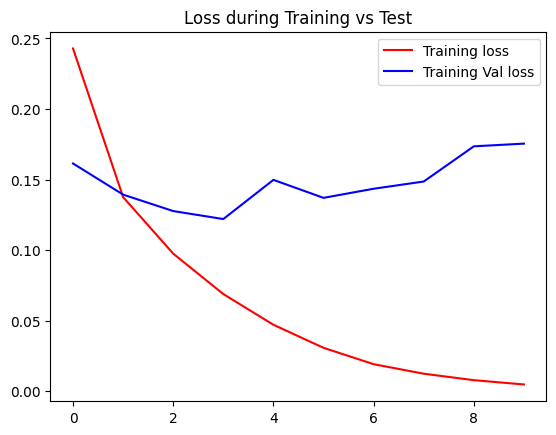

In [20]:
plt.title('Loss during Training vs Test')
plt.plot(history.history['loss'], color='red', label = 'Training loss')
plt.plot(history.history['val_loss'], color='blue', label = 'Training Val loss')
plt.legend()
plt.show()

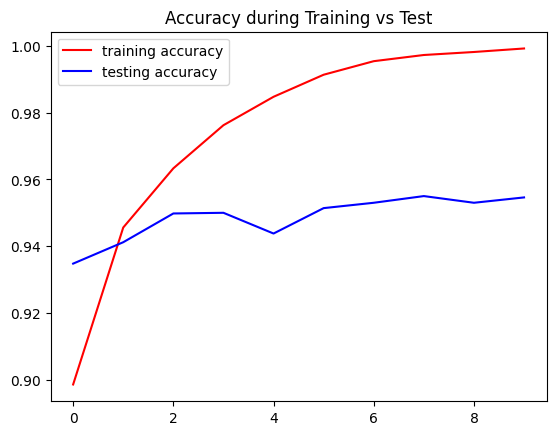

In [22]:
plt.title('Accuracy during Training vs Test')
plt.plot(history.history['accuracy'], color='red', label='training accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='testing accuracy')
plt.legend()
plt.show()

## Predicting Outcomes

In [23]:
import cv2
def predict(image_path):
  img = cv2.imread(image_path)
  plt.imshow(img)
  img = cv2.resize(img, (150, 150))
  img_input = img.reshape((1, 150, 150, 3))
  predictions = model.predict(img_input)
  return 'dog' if predictions == 1. else 'cat'

In [24]:
test_image_paths = ['/content/cat.0.jpg', '/content/cat.25.jpg', '/content/cat.263.jpg', '/content/dog.101.jpg', '/content/dog.105.jpg', '/content/dog.427.jpg']

1/1 [==============================] - 1s 726ms/step


'cat'

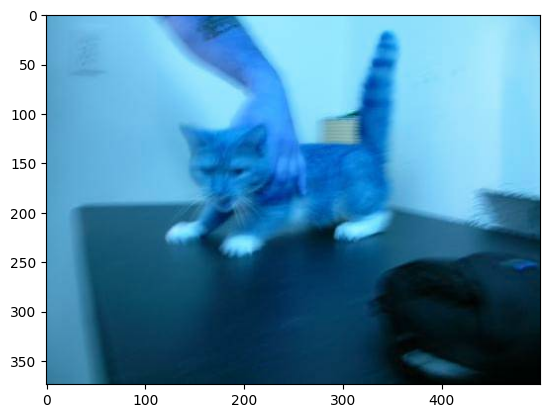

In [25]:
predict(test_image_paths[0])

1/1 [==============================] - 0s 19ms/step


'dog'

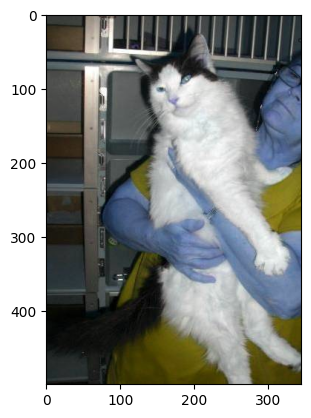

In [26]:
predict(test_image_paths[1])

1/1 [==============================] - 0s 20ms/step


'dog'

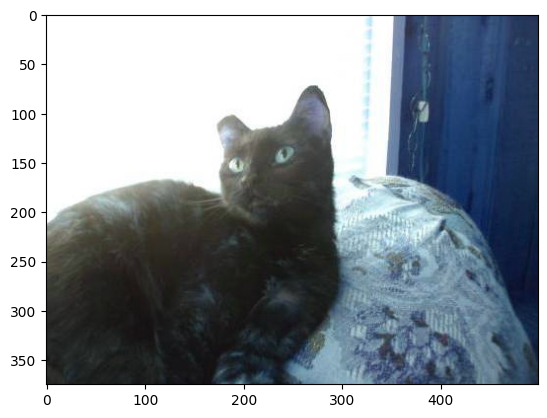

In [27]:
predict(test_image_paths[2])

1/1 [==============================] - 0s 20ms/step


'dog'

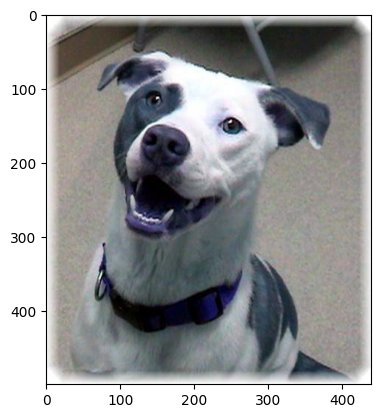

In [28]:
predict(test_image_paths[3])

1/1 [==============================] - 0s 21ms/step


'dog'

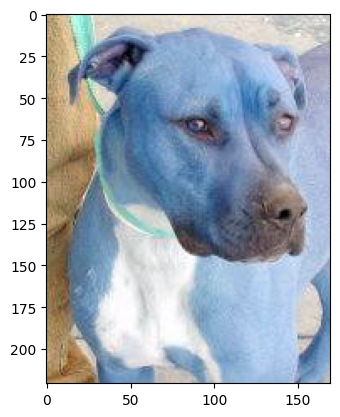

In [29]:
predict(test_image_paths[4])

1/1 [==============================] - 0s 32ms/step


'dog'

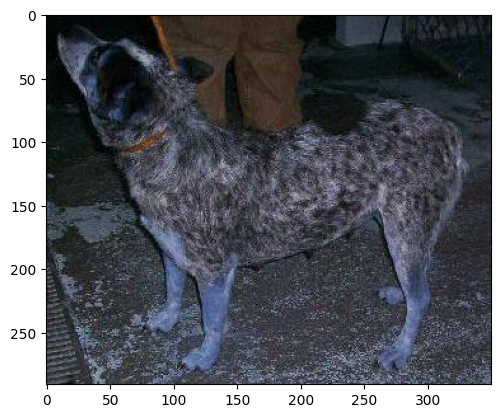

In [30]:
predict(test_image_paths[5])

## Save Model

In [31]:
model.save('finetune_vgg16_cnn.h5')